# LinkNYC_Usage_Correlation_Analysis

- Get LinkNYC kiosks location
- Get NYC zipcode shapefile
    - Aggregate LinkNYC into each zipcode area
    - Visualize the LinkNYC kiosk density in map
- Get LinkNYC monthly usage data
- Get Household broadband access data
- Get 311 data in July 2018
    - Aggregate 311 data into each zipcode area
- Correlation Analysis
    - Aggregate data together
    - 311 service requests
    - Household broadband access
    - Conclusion

In [1]:
#import libraries
import numpy as np
import pandas as pd
import pylab as pl
import geopandas as gpd
import os
import datetime as dt
from matplotlib import gridspec
import fiona
from fiona.crs import from_epsg
import shapely
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

#declare parameters
pd.set_option('display.max_columns', 500)
%pylab inline
zip_code_shpfile = os.environ['ZIP_CODE_SHPFILE']
linknyc_locations = os.environ['LINKNYC_LOCS']
policymap_broadband = os.environ['POLICYMAP_BROADBAND']
data_monthly_linknyc = os.environ['MONTHLY_LINKNYC']
socrata_key = os.environ['SOCRATA_KEY']

Populating the interactive namespace from numpy and matplotlib


## Get LinkNYC kiosks location

In [3]:
linkLocation = pd.read_csv(linknyc_locations)

In [4]:
linkLocation.head()

,CB Link ID,Borough,Community Board,Council District,Latitude,Longitude,Project Status,Smallest PPT,Street Address,Postcode,Link Site ID,Link Smoke Tested and Activated (A),Link Installation (A),Neighborhood Tabulation Area (NTA),Building Identification Number (BIN),Borough-Block-Lot (BBL),Census Tract (CT),Cross Street 1,Cross Street 2,IxN Corner,GF Permit Application ID,Location
0,LINK-019315,Bronx,205,14,40.850173,-73.910282,Live,146097,1 EAST 177 STREET,10453,bx-05-146097,07/13/2018,06/20/2018,Mount Hope,2008247,2028530001,2023301,JEROME AVENUE,WALTON AVENUE,SE,82392.0,"(40.850173, -73.91028173)"
1,LINK-008842,Manhattan,105,4,40.747114,-73.985245,Live,121611,1 EAST 32 STREET,10016,mn-05-121611,12/09/2016,10/01/2016,Midtown-Midtown South,1017006,1008620001,1007400,5 AVENUE,MADISON AVENUE,NE,NaN,"(40.74711441, -73.98524463)"
2,LINK-008843,Manhattan,105,4,40.747737,-73.984833,Live,121613,1 EAST 33 STREET,10016,mn-05-121613,03/23/2017,01/29/2017,Midtown-Midtown South,1017076,1008630006,1007400,5 AVENUE,MADISON AVENUE,NE,NaN,"(40.74773664, -73.98483344)"
3,LINK-000186,Manhattan,105,2,40.734148,-73.988740,Live,134620,1 IRVING PLACE,10003,mn-05-134620,07/19/2017,06/11/2017,Gramercy,1083247,1008707501,1005000,EAST 14 STREET,EAST 15 STREET,NW,NaN,"(40.73414765, -73.98873983)"
4,LINK-010750,Manhattan,102,3,40.730258,-74.006629,Live,123600,1 ST. LUKE'S PLACE,10014,mn-02-123600,01/26/2017,11/13/2016,West Village,1009773,1005830001,1006700,HUDSON STREET,7 AVENUE,NE,NaN,"(40.73025769, -74.00662855)"


In [5]:
linkLocation.shape

(1868, 22)

## Get NYC zipcode shapefile
- Aggregate LinkNYC into each zipcode area
- Visualize the LinkNYC kiosk density in map

In [6]:
shapefileNYC = gpd.GeoDataFrame.from_file(zip_code_shpfile)

In [7]:
shapefileNYC.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,..."


In [8]:
# sum(shapefileNYC.isna())

In [9]:
shapefileNYC.shape

(263, 13)

In [10]:
len(set(shapefileNYC['ZIPCODE']))

248

Aggregate LinkNYC into each zipcode area.

In [11]:
linkLocation['lonlat'] = list(zip(linkLocation.Longitude,linkLocation.Latitude))
linkLocation['geometry'] = linkLocation[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

linkLocation = gpd.GeoDataFrame(linkLocation)
linkLocation.crs = from_epsg(4326)

linkLocation_ft = linkLocation.to_crs(epsg=2263)
shapefileNYC_ft = shapefileNYC.to_crs(epsg=2263)

In [12]:
zipcodeCounts = gpd.sjoin(shapefileNYC_ft, linkLocation_ft).groupby('ZIPCODE').size().to_frame().rename(columns = {0: 'linknycCount'})
zipcodeCounts.reset_index(inplace = True)

In [13]:
zipcodeCounts.head()

,ZIPCODE,linknycCount
0,10001,51
1,10002,12
2,10003,71
3,10004,2
4,10005,2


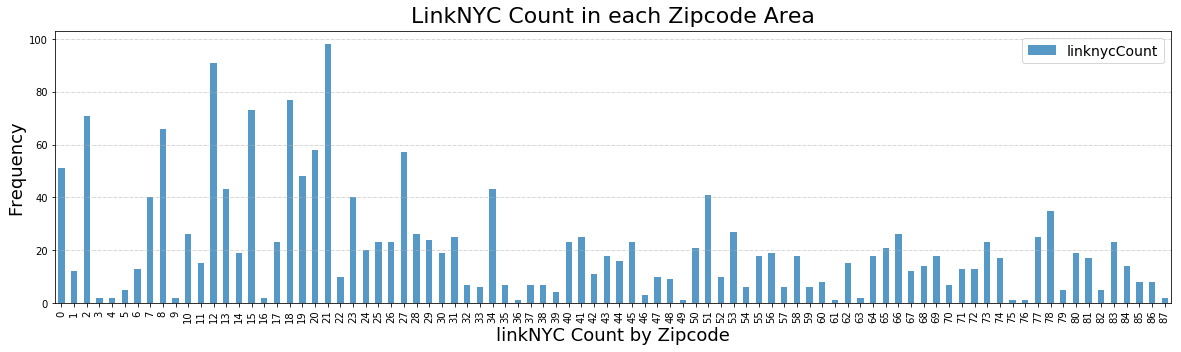

In [14]:
fig = pl.figure(figsize = (20,5))
ax = fig.add_subplot(111)

zipcodeCounts.plot.bar(alpha=0.75, ax=ax)

ax.set_title("LinkNYC Count in each Zipcode Area", fontsize=22, y=1.01)
ax.set_xlabel("linkNYC Count by Zipcode", fontsize=18)
ax.set_ylabel("Frequency", fontsize=18)


pl.grid(linewidth=0.5, axis='y', linestyle='-.')
pl.legend(fontsize=14)
pl.show()

This is the LinkNYC Count in each zipcode area. We could find that there some zipcode area has very low number of LinkNYC kiosks.

Visualize the LinkNYC kiosk density in map.

In [15]:
lowLinkArea = zipcodeCounts[zipcodeCounts['linknycCount']<5]
highLinkArea = zipcodeCounts[zipcodeCounts['linknycCount']>40]

In [16]:
lowLinkArea['linknycCount'] = 1
highLinkArea['linknycCount'] = 1

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [17]:
lowLinkArea.shape, highLinkArea.shape

((13, 2), (13, 2))

show the lowLink and high link area in the map

In [18]:
shapefileNYC = shapefileNYC.merge(zipcodeCounts, left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'left')

In [19]:
lowLinkArea.reset_index(drop = True, inplace = True)

In [20]:
highLinkArea.reset_index(drop = True, inplace = True)

In [21]:
shapefileNYC = shapefileNYC.merge(lowLinkArea, left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'left')
shapefileNYC = shapefileNYC.merge(highLinkArea, left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'left')

shapefileNYC = shapefileNYC.rename(columns = {'linknycCount_y': 'lowCount', 'linknycCount': 'highCount', 'linknycCount_x': 'linknycCount'})

In [22]:
shapefileNYC.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,linknycCount,lowCount,highCount
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",NaN,NaN,NaN
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",2.0,1.0,NaN
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",NaN,NaN,NaN
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",14.0,NaN,NaN
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",NaN,NaN,NaN


In [23]:
shapefileNYC['linknycCount'] = shapefileNYC['linknycCount'].fillna(0)
shapefileNYC['lowCount'] = shapefileNYC['lowCount'].fillna(0)
shapefileNYC['highCount'] = shapefileNYC['highCount'].fillna(0)

In [24]:
shapefileNYC.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,linknycCount,lowCount,highCount
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",0.0,0.0,0.0
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",2.0,1.0,0.0
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",0.0,0.0,0.0
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",14.0,0.0,0.0
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",0.0,0.0,0.0


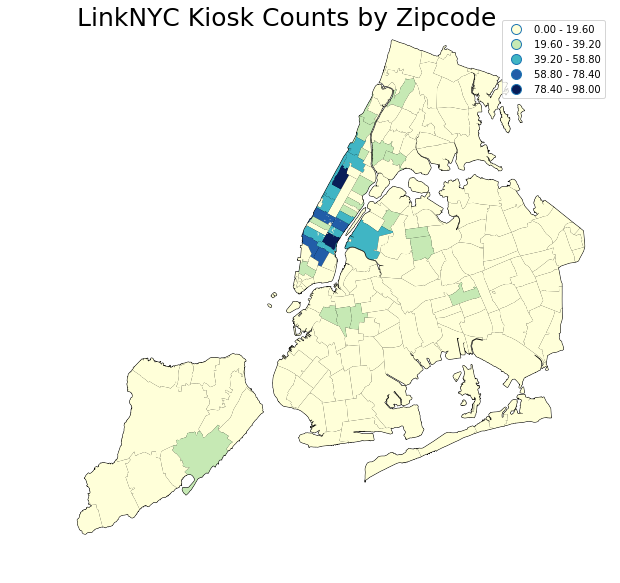

In [25]:
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)
shapefileNYC.plot(facecolor="k", edgecolor="k",ax=ax)
shapefileNYC.plot(ax=ax, column="linknycCount", cmap='YlGnBu', scheme='Equal_Interval', label='linknycCount',legend = True)
plt.title('LinkNYC Kiosk Counts by Zipcode', size=25, y=.97, x=0.42)
ax.axis('off')
plt.show()

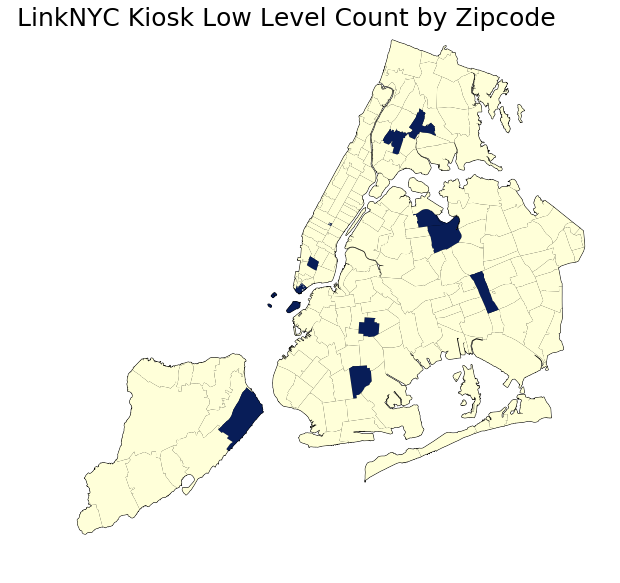

In [26]:
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)
shapefileNYC.plot(facecolor="k", edgecolor="k",ax=ax)
shapefileNYC.plot(ax=ax, column="lowCount", cmap='YlGnBu',  label='lowCount')
plt.title('LinkNYC Kiosk Low Level Count by Zipcode', size=25, y=.97, x=0.42)
ax.axis('off')
plt.show()

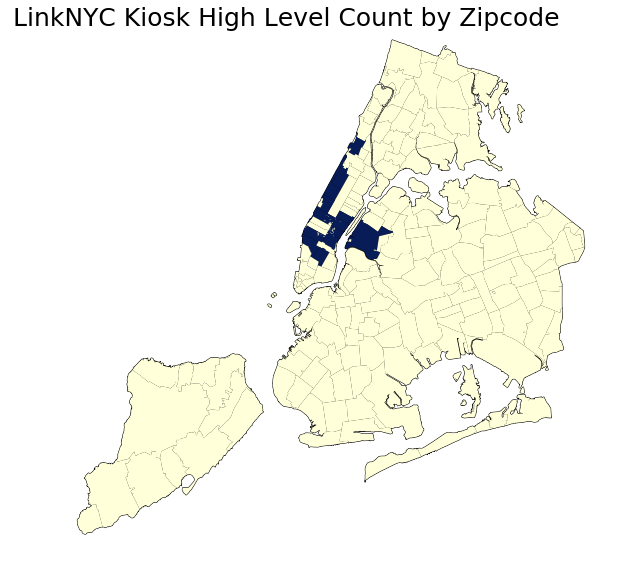

In [27]:
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)
shapefileNYC.plot(facecolor="k", edgecolor="k",ax=ax)
shapefileNYC.plot(ax=ax, column="highCount", cmap='YlGnBu', label='highCount')
plt.title('LinkNYC Kiosk High Level Count by Zipcode', size=25, y=.97, x=0.42)
ax.axis('off')
plt.show()

## Get LinkNYC monthly usage data

In [28]:
monthlyUsage = pd.read_csv(data_monthly_linknyc)

In [29]:
monthlyUsage.head()

,AP Device Name,Boro,CB,PPT ID,Street Address,Latitude,Longitude,SSID(s),Uptime %,Number of Unique Clients,Number of Sessions,Minutes Used,MB Transferred (upload),MB Transferred (download),MB Transferred (total),Daily Avg - Number of Unique Clients,Daily Avg - Number of Sessions,Daily Avg - Minutes Used,Daily Avg - MB Transferred (upload),Daily Avg - MB Transferred (download),Daily Avg - MB Transferred (total)
0,bk-01-108703,bk,1,108703,213 UNION AVENUE,40.706822,-73.950529,"LinkNYC Free Wi-Fi, LinkNYC Private, SONYC IOT",100.00%,"11,593","36,797","102,960","17,046","142,473","159,519",374,"1,187","3,321",550,"4,596","5,146"
1,bk-01-108949,bk,1,108949,709 BROADWAY,40.701419,-73.942908,"LinkNYC Free Wi-Fi, LinkNYC Private, SONYC IOT",99.87%,"25,219","75,194","234,063","41,436","327,003","368,439",814,"2,426","7,550","1,337","10,548","11,885"
2,bk-01-108952,bk,1,108952,511 BROADWAY,40.705371,-73.949963,"LinkNYC Free Wi-Fi, LinkNYC Private, SONYC IOT",100.00%,"23,497","56,722","138,142","27,941","194,260","222,201",758,"1,830","4,456",901,"6,266","7,168"
3,bk-01-109091,bk,1,109091,24 GRAHAM AVENUE,40.701542,-73.942169,"LinkNYC Free Wi-Fi, LinkNYC Private, SONYC IOT",99.87%,"9,336","31,424","179,954","18,587","246,474","265,060",301,"1,014","5,805",600,"7,951","8,550"
4,bk-01-109252,bk,1,109252,395 BROADWAY,40.707208,-73.954195,"LinkNYC Free Wi-Fi, LinkNYC Private, SONYC IOT",100.00%,"35,990","107,471","298,471","52,864","359,326","412,189","1,894","5,656","15,709","2,782","18,912","21,694"


## Get Household broadband access data

In [30]:
policyData = pd.read_csv(policymap_broadband)

In [31]:
policyData.head()

,Zip Code Tabulation Area,FIPS Code,Formatted FIPS,Estimated percent of households with a subscription to broadband
0,10314,10314.0,"=""10314""",78.71
1,11234,11234.0,"=""11234""",75.72
2,10312,10312.0,"=""10312""",81.77
3,10306,10306.0,"=""10306""",75.95
4,11430,11430.0,"=""11430""",NaN


In [32]:
policyData.shape

(217, 4)

In [33]:
# sum(policyData.isna())

In [34]:
policyData.dropna(inplace=True)

In [35]:
policyData.shape

(179, 4)

In [36]:
len(set(policyData['Zip Code Tabulation Area']))

179

## Get 311 data in July 2018
- Aggregate 311 data into each zipcode area

In [ ]:
client = Socrata("data.cityofnewyork.us",
                 socrata_key)

results = client.get("fhrw-4uyv", where = "created_date BETWEEN  '2018-07-01T00:00:00' AND '2018-07-31T00:00:00'", limit = 300000)

data311 = pd.DataFrame.from_records(results)

In [38]:
data311.shape

(229683, 41)

In [39]:
data311.head()

,address_type,agency,agency_name,bbl,borough,bridge_highway_direction,bridge_highway_name,bridge_highway_segment,city,closed_date,community_board,complaint_type,created_date,cross_street_1,cross_street_2,descriptor,due_date,facility_type,incident_address,incident_zip,intersection_street_1,intersection_street_2,landmark,latitude,location,location_type,longitude,open_data_channel_type,park_borough,park_facility_name,resolution_action_updated_date,resolution_description,road_ramp,status,street_name,taxi_company_borough,taxi_pick_up_location,unique_key,vehicle_type,x_coordinate_state_plane,y_coordinate_state_plane
0,ADDRESS,DOHMH,Department of Health and Mental Hygiene,1.009090e+09,MANHATTAN,NaN,NaN,NaN,NEW YORK,2018-07-05T14:13:30.000,06 MANHATTAN,Rodent,2018-07-01T00:00:00.000,EAST 28 STREET,EAST 29 STREET,Mouse Sighting,2018-07-31T01:40:36.000,NaN,519 2 AVENUE,10016,NaN,NaN,NaN,40.741555,"{'type': 'Point', 'coordinates': [-73.97824313...",3+ Family Apt. Building,-73.978243,ONLINE,MANHATTAN,Unspecified,2018-07-05T14:13:30.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,2 AVENUE,NaN,NaN,39612067,NaN,990279.0,209446.0
1,ADDRESS,DOHMH,Department of Health and Mental Hygiene,3.076760e+09,BROOKLYN,NaN,NaN,NaN,BROOKLYN,NaN,14 BROOKLYN,Rodent,2018-07-01T00:00:00.000,BAY AVENUE,AVENUE O,Rat Sighting,2018-07-31T01:47:58.000,NaN,1523 EAST 22 STREET,11210,NaN,NaN,NaN,40.614591,"{'type': 'Point', 'coordinates': [-73.95227564...",1-2 Family Dwelling,-73.952276,PHONE,BROOKLYN,Unspecified,2018-07-01T01:51:48.000,The Department of Health and Mental Hygiene wi...,NaN,Assigned,EAST 22 STREET,NaN,NaN,39612795,NaN,997500.0,163192.0
2,ADDRESS,DSNY,Department of Sanitation,1.004470e+09,MANHATTAN,NaN,NaN,NaN,NEW YORK,2018-07-03T00:00:00.000,03 MANHATTAN,Request Large Bulky Item Collection,2018-07-01T00:00:00.000,2 AVENUE,1 AVENUE,Request Large Bulky Item Collection,NaN,NaN,339 EAST 5 STREET,10003,NaN,NaN,NaN,40.726365,"{'type': 'Point', 'coordinates': [-73.98797493...",Sidewalk,-73.987975,PHONE,MANHATTAN,Unspecified,2018-07-03T00:00:00.000,NaN,NaN,Closed,EAST 5 STREET,NaN,NaN,39613462,NaN,987583.0,203911.0
3,ADDRESS,DOHMH,Department of Health and Mental Hygiene,3.082720e+09,BROOKLYN,NaN,NaN,NaN,BROOKLYN,2018-07-10T00:00:00.000,18 BROOKLYN,Standing Water,2018-07-01T00:00:00.000,EAST 105 STREET,EAST 108 STREET,Swimming Pool - Unmaintained,2018-07-31T23:16:15.000,NaN,10554 FLATLANDS 6 STREET,11236,NaN,NaN,NaN,40.642262,"{'type': 'Point', 'coordinates': [-73.88685536...",1-2 Family Dwelling,-73.886855,ONLINE,BROOKLYN,Unspecified,2018-07-09T00:00:00.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,FLATLANDS 6 STREET,NaN,NaN,39613819,NaN,1015650.0,173290.0
4,ADDRESS,DOHMH,Department of Health and Mental Hygiene,5.003740e+09,STATEN ISLAND,NaN,NaN,NaN,STATEN ISLAND,2018-07-01T00:00:00.000,01 STATEN ISLAND,Rodent,2018-07-01T00:00:00.000,ELMIRA AVENUE,CONSTANT AVENUE,Condition Attracting Rodents,2018-07-31T21:36:54.000,NaN,41 WESTCOTT BOULEVARD,10314,NaN,NaN,NaN,40.619533,"{'type': 'Point', 'coordinates': [-74.12801163...",1-2 Family Dwelling,-74.128012,ONLINE,STATEN ISLAND,Unspecified,2018-07-01T21:39:37.000,The Department of Health and Mental Hygiene wi...,NaN,Closed,WESTCOTT BOULEVARD,NaN,NaN,39614027,NaN,948712.0,165015.0


In [40]:
data311['lonlat'] = list(zip(data311.longitude.astype(float),data311.latitude.astype(float)))
data311['geometry'] = data311[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [41]:
data311 = gpd.GeoDataFrame(data311)
data311.crs = from_epsg(4326)
data311_ft = data311.to_crs(epsg=2263)

## Correlation Analysis
- Aggregate data together
- 311 service requests
- Household broadband access
- Conclusion

Aggregate data together.

In [42]:
shapefileNYC = shapefileNYC.merge(policyData, right_on = "Zip Code Tabulation Area", left_on = "ZIPCODE", how = 'right')

In [43]:
shapefileNYC.shape

(191, 20)

In [44]:
#shapeNYCwithPolicy.drop_duplicates(subset=['A', 'C'], keep=False)

In [45]:
# sum(shapefileNYC.isna())

In [46]:
len(set(shapefileNYC['ZIPCODE']))

179

In [47]:
shapefileNYC.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,linknycCount,lowCount,highCount,Zip Code Tabulation Area,FIPS Code,Formatted FIPS,Estimated percent of households with a subscription to broadband
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",0.0,0.0,0.0,11436,11436.0,"=""11436""",65.37
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",2.0,1.0,0.0,11213,11213.0,"=""11213""",62.95
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",0.0,0.0,0.0,11212,11212.0,"=""11212""",58.12
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",14.0,0.0,0.0,11225,11225.0,"=""11225""",67.98
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",0.0,0.0,0.0,11218,11218.0,"=""11218""",70.67


In [48]:
shapefileNYC.drop(['Zip Code Tabulation Area', 'FIPS Code', 'Formatted FIPS'], axis = 1, inplace = True)

In [49]:
shapefileNYC.head()

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,linknycCount,lowCount,highCount,Estimated percent of households with a subscription to broadband
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",0.0,0.0,0.0,65.37
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",2.0,1.0,0.0,62.95
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.275535807 183696.33770971, 1...",0.0,0.0,0.0,58.12
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.3654508889 183617.6128015518,...",14.0,0.0,0.0,67.98
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.1134308875 176307.4958601296,...",0.0,0.0,0.0,70.67


In [50]:
shapefileNYC_ft = shapefileNYC.to_crs(epsg=2263)

In [51]:
monthlyUsage['lonlat'] = list(zip(monthlyUsage.Longitude,monthlyUsage.Latitude))
monthlyUsage['geometry'] = monthlyUsage[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

In [52]:
monthlyUsage = gpd.GeoDataFrame(monthlyUsage)

In [53]:
monthlyUsage.crs = from_epsg(4326)

In [54]:
monthlyUsage_ft = monthlyUsage.to_crs(epsg=2263)

In [55]:
monthlyUsageZipcode = gpd.sjoin(shapefileNYC_ft, monthlyUsage_ft)

In [56]:
monthlyUsageZipcode.reset_index(drop = True, inplace = True)

In [57]:
monthlyUsageZipcode.head(1)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,linknycCount,lowCount,highCount,Estimated percent of households with a subscription to broadband,index_right,AP Device Name,Boro,CB,PPT ID,Street Address,Latitude,Longitude,SSID(s),Uptime %,Number of Unique Clients,Number of Sessions,Minutes Used,MB Transferred (upload),MB Transferred (download),MB Transferred (total),Daily Avg - Number of Unique Clients,Daily Avg - Number of Sessions,Daily Avg - Minutes Used,Daily Avg - MB Transferred (upload),Daily Avg - MB Transferred (download),Daily Avg - MB Transferred (total),lonlat
0,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395171622,...",2.0,1.0,0.0,62.95,94,bk-03-145749,bk,3,145749,1628 FULTON STREET,40.679561,-73.9355,"LinkNYC Free Wi-Fi, LinkNYC Private, SONYC IOT",100.00%,"15,182","42,873","111,437","22,290","186,040","208,330",490,"1,383","3,595",719,"6,001","6,720","(-73.93549973, 40.67956068)"


In [58]:
monthlyUsageZipcode.drop(['BLDGZIP', 'CTY_FIPS', 'ST_FIPS', 'SSID(s)', 'STATE', 'COUNTY', 'URL', 'SHAPE_AREA', 'SHAPE_LEN', 'index_right', 'Boro', ], axis = 1, inplace = True)

In [59]:
monthlyUsageZipcode.head()

,ZIPCODE,PO_NAME,POPULATION,AREA,geometry,linknycCount,lowCount,highCount,Estimated percent of households with a subscription to broadband,AP Device Name,CB,PPT ID,Street Address,Latitude,Longitude,Uptime %,Number of Unique Clients,Number of Sessions,Minutes Used,MB Transferred (upload),MB Transferred (download),MB Transferred (total),Daily Avg - Number of Unique Clients,Daily Avg - Number of Sessions,Daily Avg - Minutes Used,Daily Avg - MB Transferred (upload),Daily Avg - MB Transferred (download),Daily Avg - MB Transferred (total),lonlat
0,11213,Brooklyn,62426.0,2.963100e+07,"POLYGON ((1001613.712964058 186926.4395171622,...",2.0,1.0,0.0,62.95,bk-03-145749,3,145749,1628 FULTON STREET,40.679561,-73.935500,100.00%,"15,182","42,873","111,437","22,290","186,040","208,330",490,"1,383","3,595",719,"6,001","6,720","(-73.93549973, 40.67956068)"
1,11213,Brooklyn,62426.0,2.963100e+07,"POLYGON ((1001613.712964058 186926.4395171622,...",2.0,1.0,0.0,62.95,bk-03-145759,3,145759,1546 FULTON STREET,40.679752,-73.939101,100.00%,"13,998","54,966","300,095","41,523","297,594","339,118",452,"1,773","9,680","1,339","9,600","10,939","(-73.93910101, 40.67975193)"
2,11225,Brooklyn,56527.0,2.369863e+07,"POLYGON ((995908.3654508896 183617.6128014964,...",14.0,0.0,0.0,67.98,bk-09-127022,9,127022,1208 NOSTRAND AVENUE,40.657740,-73.950407,100.00%,"12,421","58,252","303,969","38,068","424,068","462,136",401,"1,879","9,805","1,228","13,680","14,908","(-73.95040697, 40.65773965)"
3,11225,Brooklyn,56527.0,2.369863e+07,"POLYGON ((995908.3654508896 183617.6128014964,...",14.0,0.0,0.0,67.98,bk-09-127021,9,127021,1106 NOSTRAND AVENUE,40.660732,-73.950727,99.87%,"10,060","35,284","140,386","22,479","181,024","203,503",325,"1,138","4,529",725,"5,839","6,565","(-73.95072664, 40.6607318)"
4,11225,Brooklyn,56527.0,2.369863e+07,"POLYGON ((995908.3654508896 183617.6128014964,...",14.0,0.0,0.0,67.98,bk-09-145844,9,145844,317 LEFFERTS AVENUE,40.662438,-73.950605,99.87%,"9,418","37,671","128,707","14,693","175,966","190,658",304,"1,215","4,152",474,"5,676","6,150","(-73.950605, 40.662438)"


In [60]:
columnName = ['Number of Unique Clients', 'Number of Sessions', 'Minutes Used', 'MB Transferred (upload)', 'MB Transferred (download)', 
              'MB Transferred (total)', 'Daily Avg - Number of Unique Clients', 'Daily Avg - Number of Sessions', 'Daily Avg - Minutes Used', 
              'Daily Avg - MB Transferred (upload)', 'Daily Avg - MB Transferred (download)', 'Daily Avg - MB Transferred (total)']

In [61]:
for name in columnName:
    monthlyUsageZipcode[name] = monthlyUsageZipcode[name].apply(lambda x: x.replace(',', ''))
    monthlyUsageZipcode[name] = monthlyUsageZipcode[name].astype('float') 

In [62]:
monthlyUsageZipcodeMean = monthlyUsageZipcode.groupby('ZIPCODE').mean()[columnName].reset_index()

In [63]:
shapefileUsage = shapefileNYC.merge(monthlyUsageZipcodeMean)

In [64]:
shapefileUsage.head(1)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,linknycCount,lowCount,highCount,Estimated percent of households with a subscription to broadband,Number of Unique Clients,Number of Sessions,Minutes Used,MB Transferred (upload),MB Transferred (download),MB Transferred (total),Daily Avg - Number of Unique Clients,Daily Avg - Number of Sessions,Daily Avg - Minutes Used,Daily Avg - MB Transferred (upload),Daily Avg - MB Transferred (download),Daily Avg - MB Transferred (total)
0,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",2.0,1.0,0.0,62.95,14590.0,48919.5,205766.0,31906.5,241817.0,273724.0,471.0,1578.0,6637.5,1029.0,7800.5,8829.5


In [65]:
monthlyUsage311 = gpd.sjoin(shapefileNYC_ft, data311_ft).groupby('ZIPCODE').size().to_frame()
monthlyUsage311.reset_index(inplace = True)

In [66]:
monthlyUsage311.rename(columns={monthlyUsage311.columns[1]: "311number" }, inplace=True)
monthlyUsage311.head()

,ZIPCODE,311number
0,10001,992
1,10002,1440
2,10003,1291
3,10004,156
4,10005,181


In [67]:
shapefileUsage = shapefileUsage.merge(monthlyUsage311, left_on = 'ZIPCODE', right_on = 'ZIPCODE', how = 'left')

311 service requests

In [68]:
shapefileUsage.corr()['311number']

POPULATION                                                          0.786257
AREA                                                                0.454014
SHAPE_AREA                                                               NaN
SHAPE_LEN                                                                NaN
linknycCount                                                       -0.043421
lowCount                                                           -0.165267
highCount                                                          -0.108879
Estimated percent of households with a subscription to broadband   -0.563787
Number of Unique Clients                                           -0.310016
Number of Sessions                                                 -0.247950
Minutes Used                                                       -0.058686
MB Transferred (upload)                                            -0.183167
MB Transferred (download)                                           0.054910

Household broadband access

In [69]:
shapefileUsage.corr()['Estimated percent of households with a subscription to broadband']

POPULATION                                                         -0.517715
AREA                                                               -0.260298
SHAPE_AREA                                                               NaN
SHAPE_LEN                                                                NaN
linknycCount                                                        0.231360
lowCount                                                            0.178624
highCount                                                           0.315535
Estimated percent of households with a subscription to broadband    1.000000
Number of Unique Clients                                            0.298728
Number of Sessions                                                  0.234978
Minutes Used                                                        0.042819
MB Transferred (upload)                                             0.153618
MB Transferred (download)                                          -0.147193

Specifically, we correlated complaint counts in each zip code and LinkNYC monthly number of unique clients. We did it in each zip code. We found that the more people use LinkNYC kiosk, the less 311 complaint counts, which is a negative correlation. 